In [5]:
import sys
import sklearn
import os
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
from functools import partial
import PIL
import PIL.Image
import random as python_random

import tensorflow as tf
from tensorflow import keras

np.random.seed(42) # note that you must use the same seed to ensure consistentcy in your training/validation/testing
tf.random.set_seed(42)

In [6]:
!ls ../dl_data

Covid_img  Normal_img  Viral_img


In [7]:
data_path = '../dl_data/'
class_names = os.listdir(data_path)
for c in class_names:
    print(len(os.listdir(data_path + c)))

3610
1345
10192


In [8]:
from sklearn.datasets import load_files 
from keras.utils import np_utils

from keras.preprocessing import image

data_dir = "../dl_data"
batch_size = 32;
# IMPORTANT: Depends on what pre-trained model you choose, you will need to change these dimensions accordingly
img_height = 299; 
img_width = 299;

# Training Dataset
train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "training",
    seed = 42,
    image_size= (img_height, img_width),
    batch_size = batch_size
)

# Validation Dataset
validation_ds = tf.keras.preprocessing.image_dataset_from_directory(
    data_dir,
    validation_split = 0.2,
    subset = "validation",
    seed = 42,
    image_size = (img_height, img_width),
    batch_size = batch_size
)     

Found 15147 files belonging to 3 classes.
Using 12118 files for training.


2022-04-12 02:46:58.927411: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2022-04-12 02:47:00.798978: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 10789 MB memory:  -> device: 0, name: Tesla K80, pci bus id: 0000:85:00.0, compute capability: 3.7


Found 15147 files belonging to 3 classes.
Using 3029 files for validation.


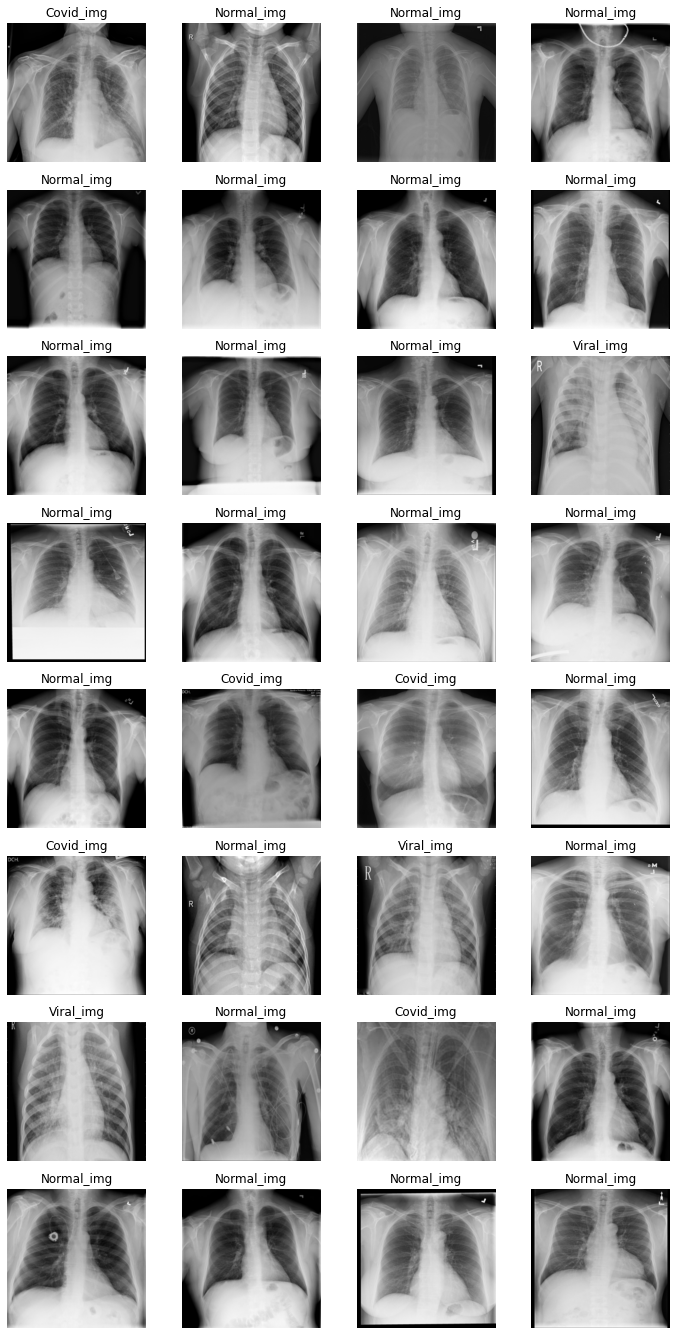

In [9]:
# Visualize some of the train samples of one batch
# Make sure you create the class names that match the order of their appearances in the "files" variable
class_names = ['Covid_img',  'Normal_img',  'Viral_img']

# Rows and columns are set to fit one training batch (32)
n_rows = 8
n_cols = 4
plt.figure(figsize=(n_cols * 3, n_rows * 3))
for images, labels in train_ds.take(1):
    for i in range (n_rows*n_cols):
        plt.subplot(n_rows, n_cols, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis('off')
        plt.title(class_names[labels[i]], fontsize=12)
plt.subplots_adjust(wspace=.2, hspace=.2)

In [10]:
ds_size_1 = (224, 224)
train_ds_1 = train_ds.map(lambda image, label: (tf.image.resize(image, ds_size_1), label))
validation_ds_1 = validation_ds.map(lambda image, label: (tf.image.resize(image, ds_size_1), label))

base_model_1 = keras.applications.ResNet50(weights='imagenet', include_top=False)
n_classes = 18

callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=5)

# Rebuild top
x = tf.keras.layers.GlobalAveragePooling2D(name="avg_pool")(base_model_1.output)
x = tf.keras.layers.BatchNormalization()(x)

top_dropout_rate = 0.2
x = tf.keras.layers.Dropout(top_dropout_rate, name="top_dropout")(x)
outputs = tf.keras.layers.Dense(18, activation="softmax", name="pred")(x)

model_1 = keras.models.Model(inputs=base_model_1.input,
                           outputs=outputs)

In [11]:
# train up the top layer first

for layer in base_model_1.layers:
    layer.trainable = False

optimizer = keras.optimizers.Adam(learning_rate=0.01, decay=0.01)
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model_1.fit(train_ds_1,
                    validation_data=validation_ds_1,
                    epochs=20, callbacks=[callback])

Epoch 1/20


2022-04-12 02:48:50.326870: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8101


379/379 [==============================] - 102s 246ms/step - loss: 0.4976 - accuracy: 0.9010 - val_loss: 0.2129 - val_accuracy: 0.9442
Epoch 2/20
379/379 [==============================] - 92s 242ms/step - loss: 0.2200 - accuracy: 0.9373 - val_loss: 0.1695 - val_accuracy: 0.9505
Epoch 3/20
379/379 [==============================] - 92s 242ms/step - loss: 0.1776 - accuracy: 0.9442 - val_loss: 0.1414 - val_accuracy: 0.9558
Epoch 4/20
379/379 [==============================] - 92s 241ms/step - loss: 0.1487 - accuracy: 0.9529 - val_loss: 0.1269 - val_accuracy: 0.9597
Epoch 5/20
379/379 [==============================] - 92s 242ms/step - loss: 0.1301 - accuracy: 0.9555 - val_loss: 0.1203 - val_accuracy: 0.9587
Epoch 6/20
379/379 [==============================] - 92s 242ms/step - loss: 0.1270 - accuracy: 0.9559 - val_loss: 0.1143 - val_accuracy: 0.9617
Epoch 7/20
379/379 [==============================] - 92s 242ms/step - loss: 0.1208 - accuracy: 0.9574 - val_loss: 0.1164 - val_accuracy: 0.

In [ ]:
# train all the layers together for a bit with a much lower learning rate

for layer in base_model_1.layers[-20:]:
    if not isinstance(layer, tf.keras.layers.BatchNormalization):
        layer.trainable = True

optimizer = keras.optimizers.Adam(learning_rate=0.0004, decay=0.001)
model_1.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer,
              metrics=["accuracy"])
history = model_1.fit(train_ds_1,
                    validation_data=validation_ds_1,
                    epochs=50, callbacks=[callback])

Epoch 1/50
379/379 [==============================] - 111s 283ms/step - loss: 0.2126 - accuracy: 0.9352 - val_loss: 0.1540 - val_accuracy: 0.9554
Epoch 2/50
379/379 [==============================] - 106s 279ms/step - loss: 0.0890 - accuracy: 0.9704 - val_loss: 0.1770 - val_accuracy: 0.9518
Epoch 3/50
379/379 [==============================] - 106s 279ms/step - loss: 0.0582 - accuracy: 0.9818 - val_loss: 0.0760 - val_accuracy: 0.9700
Epoch 4/50
379/379 [==============================] - 106s 280ms/step - loss: 0.0378 - accuracy: 0.9870 - val_loss: 0.0460 - val_accuracy: 0.9828
Epoch 5/50
379/379 [==============================] - 106s 279ms/step - loss: 0.0306 - accuracy: 0.9894 - val_loss: 0.0475 - val_accuracy: 0.9809
Epoch 6/50
379/379 [==============================] - 106s 279ms/step - loss: 0.0203 - accuracy: 0.9936 - val_loss: 0.0606 - val_accuracy: 0.9802
Epoch 7/50
379/379 [==============================] - 106s 280ms/step - loss: 0.0123 - accuracy: 0.9960 - val_loss: 0.0394 -